In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from category_encoders import MEstimateEncoder
from sklearn.linear_model import ElasticNet
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.mixture import GaussianMixture
from xgboost import XGBRegressor

# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

In [3]:

def make_mi_scores(X, y):
    X = X.copy()
    # All discrete features should now have integer dtypes
    mi_scores = mutual_info_regression(X, y, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(
        100 * (start_mem - end_mem) / start_mem))

    return df


def import_data(file):
    # Reading File
    df = pd.read_csv(file)

    # Reducing Size by Optimizing Dtypes of columns
    df = reduce_mem_usage(df)

    # Converting Bool cols into integer
    bool_cols = []
    for i, col in enumerate(df.columns):
        if df[col].dtypes == bool:
            bool_cols.append(i)
    df.iloc[:, bool_cols] = df.iloc[:, bool_cols].astype(int)

    return df


In [5]:
train_data_path = "train.csv"
df_train = import_data(train_data_path)


Memory usage of dataframe is 2189.64 MB
Memory usage after optimization is: 505.45 MB
Decreased by 76.9%


In [170]:
df_smaller = df_train.sample(random_state=1, n=10000, axis=0)
X_train, X_test, y_train, y_test = train_test_split(df_smaller.loc[:,"f0":"f284"], df_smaller["target"], test_size=0.2, random_state=42)

In [171]:
mi_scores = make_mi_scores(X_train, y_train)

In [8]:
X_train = X_train.loc[:, mi_scores > 0]

In [46]:
xgb_params = dict(
    #objective = "binary",
    eval_metric = roc_auc_score,
    max_depth=5,           # maximum depth of each tree - try 2 to 10
    learning_rate=0.01,    # effect of each tree - try 0.0001 to 0.1
    n_estimators=1000,     # number of trees (that is, boosting rounds) - try 1000 to 8000
    min_child_weight=2,    # minimum number of houses in a leaf - try 1 to 10
    colsample_bytree=0.2,  # fraction of features (columns) per tree - try 0.2 to 1.0
    subsample=0.7,         # fraction of instances (rows) per tree - try 0.2 to 1.0
    reg_alpha=3,         # L1 regularization (like LASSO) - try 0.0 to 10.0
    reg_lambda=2.0,        # L2 regularization (like Ridge) - try 0.0 to 10.0
    num_parallel_tree=1,   # set > 1 for boosted random forests
)

def run_model(x_tr, y_tr, x_te, y_te):
    model = XGBRegressor(**xgb_params)
    model.fit(x_tr, y_tr)
    # X_test = df_test.loc[:,"f0":"f284"]
    # print(X_test.loc[:100, mi_scores > 0.0])
    predictions = model.predict(x_te.loc[:,mi_scores > 0])
    return roc_auc_score(y_te, predictions)

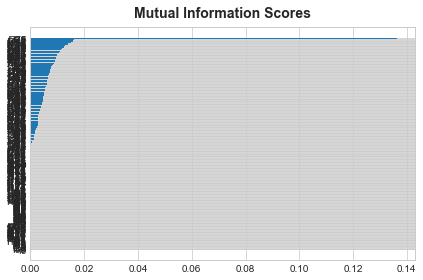

In [10]:
plot_mi_scores(mi_scores)

c:\Users\antho\repos\Kaggle\venv\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


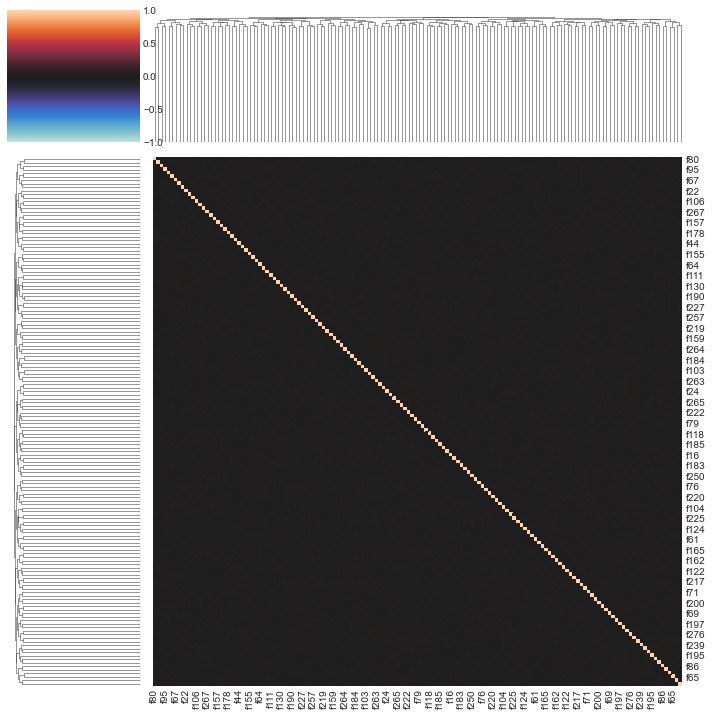

In [11]:
def corrplot(df, method="pearson", annot=True, **kwargs):
    sns.clustermap(
        df.corr(method),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        **kwargs,
    )


corrplot(X_train, annot=None)

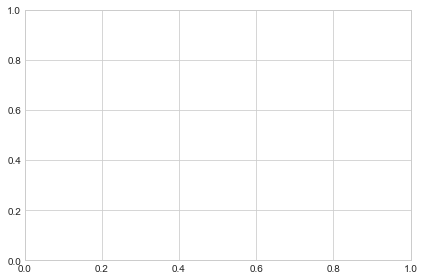

In [12]:
for column in X_train.columns:
    if X_train[column].dtype == "float64":
        plt.clf()
        plt.cla()
        this, that, obj = plt.hist(X_train[column], bins=30)
        plt.savefig("pics/" + column)
plt.clf()
plt.cla()
        #this.clear()
        #that.clear()
        #obj.clear()

        # ax.set_title(column)
        # fig.savefig(column)

In [13]:
features_for_kmeans2 = [
    "f33",
    "f50",
    "f72", 
    "f75",
    "f78",
    "f90",
    "f92",
    "f95", 
    "f102",
    "f108",
    "f110",
    "f114",
    "f116",
    "f117",
    "f118",
    "f124",
    "f135",
    "f138",
    "f139",
    "f140",
    "f141",
    "f142",
    "f146",
    "f150",
    "f151",
    "f155",
    "f156",
    "f157",
    "f158",
    "f160",
    "f162",
    "f165",
    "f166",
    "f167",
    "f168",
    "f170",
    "f171",
    "f172",
    "f174",
    "f179",
    "f182",
    "f184",
    "f230",
    "f203",
    "f234",
    "f237",
    "f224",
    "f225",
]
features_for_kmeans3 = [
    "f58", # 3
    "f93", # 3x split?
    "f94", # 3
    "f214",
    "f192"
    "f207",
    "f219",
    "f217",
]
features_for_kmeans4 = [
    "f239"
]
features_for_gmm = [
    "f8",
    "f50",
    "f145",
    "f147",
    "f148",
]
features_to_log = [
    "f2",
    "f9",
    "f18",
    "f29",
    "f31",
    "f32",
    "f37",
    "f42",
    "f47",
    "f50",
    "f53",
    "f55",
    "f58",
    "f63",
    "f64",
    "f69",
    "f71",
    "f87", 
    "f109",
    "f112",
    "f118",
    "f123",
    "f128",
    "f175",
    "f176",
    "f183",
    "f185",
    "f200",
    "f202",
    "f211",
    "f212",
    "f231",
    "f236",
    "f238",
    "f240",
]
features_to_exp = [
    "f81"
]

In [172]:
df_transform = df_train.sample(random_state=1, n=10000, axis=0)
df_transform2 = df_transform.loc[:,"f0":"f284"]
Xx_train, Xx_test, yy_train, yy_test = train_test_split(df_transform2.loc[:,mi_scores > 0], df_transform["target"], test_size=0.2, random_state=42)

In [173]:
def run_model(x_tr, y_tr, x_te, y_te):
    model = XGBRegressor(**xgb_params)
    model.fit(x_tr, y_tr)
    # X_test = df_test.loc[:,"f0":"f284"]
    # print(X_test.loc[:100, mi_scores > 0.0])
    predictions = model.predict(x_te)
    return model, predictions, roc_auc_score(y_te, predictions)

In [174]:
print(run_model(Xx_train, yy_train, Xx_test, yy_test)[2])

for feature in set(Xx_train.columns).intersection(features_to_log):
    Xx_train[feature] = Xx_train[feature].map(lambda x: math.log(x))
for feature in set(Xx_train.columns).intersection(features_to_log):
    Xx_test[feature] = Xx_test[feature].map(lambda x: math.log(x))

print(run_model(Xx_train, yy_train, Xx_test, yy_test)[2])



0.8421952862357243
0.8425686001927621


In [147]:

# kmeans = KMeans(n_clusters=2, n_init=50, max_iter=500, random_state=42)

# # train
# for feature in set(Xx_train.columns).intersection(features_for_kmeans2):
#     temp_col = feature + "-clusters"
    
#     Xx_train[temp_col] = kmeans.fit_predict(Xx_train[feature].to_numpy().reshape(-1,1))
#     Xx_train[feature + "-0"] = Xx_train.apply(lambda row: row[feature] if row[temp_col] else 0, axis = 1)
#     Xx_train[feature + "-1"] = Xx_train.apply(lambda row: row[feature] if not row[temp_col] else 0, axis = 1)
#     Xx_train = Xx_train.drop([temp_col], axis=1)

#     Xx_test[temp_col] = kmeans.fit(Xx_test[feature].to_numpy().reshape(-1,1))
#     Xx_test[feature + "-0"] = Xx_test.apply(lambda row: row[feature] if row[temp_col] else 0, axis = 1)
#     Xx_test[feature + "-1"] = Xx_test.apply(lambda row: row[feature] if not row[temp_col] else 0, axis = 1)
#     Xx_test = Xx_test.drop([temp_col], axis=1)




# X_cd = pd.DataFrame(X_cd, columns="f33" + "-1", index=df_training.index)
# df_training = df_training.join(X_cd)
# # test
# X_cd = kmeans.transform(df_test[useful_features])
# X_cd = pd.DataFrame(X_cd, columns=cluster_cols, index=df_test.index)
# df_test = df_test.join(X_cd)

In [187]:

clusterer = GaussianMixture(n_components=2, max_iter=500, random_state=42)

# train
for feature in set(Xx_train.columns).intersection(features_for_gmm):
    temp_col = feature + "-clusters"
    
    Xx_train[temp_col] = clusterer.fit_predict(Xx_train[feature].to_numpy().reshape(-1,1))
    Xx_train[feature + "-0"] = Xx_train.apply(lambda row: row[feature] if row[temp_col] else 0, axis = 1)
    Xx_train[feature + "-1"] = Xx_train.apply(lambda row: row[feature] if not row[temp_col] else 0, axis = 1)
    Xx_train = Xx_train.drop([temp_col], axis=1)

    Xx_test[temp_col] = clusterer.predict(Xx_test[feature].to_numpy().reshape(-1,1))
    Xx_test[feature + "-0"] = Xx_test.apply(lambda row: row[feature] if row[temp_col] else 0, axis = 1)
    Xx_test[feature + "-1"] = Xx_test.apply(lambda row: row[feature] if not row[temp_col] else 0, axis = 1)
    Xx_test = Xx_test.drop([temp_col], axis=1)




In [192]:
Xx_test[temp_col] = clusterer.predict(Xx_test[feature].to_numpy().reshape(-1,1))
Xx_test = Xx_test.drop([temp_col], axis=1)


In [188]:
mi_scores = make_mi_scores(Xx_train, yy_train)

In [193]:

m, p, s = run_model(Xx_train, yy_train, Xx_test, yy_test)
print(s)


0.8416818544395837


In [194]:
m, p, s = run_model(Xx_train.loc[:,mi_scores>0], yy_train, Xx_test.loc[:,mi_scores>0], yy_test)
print(s)

0.8415387340753574


In [157]:
print(X_train.loc[:,mi_scores>0].shape)

(8000, 95)


In [ ]:
cd_feature = True # cluster distance instead of cluster number
cluster_cols = [f"cluster{i+1}" for i in range(n_clusters_1)]
kmeans = KMeans(n_clusters=2, n_init=50, max_iter=500, random_state=42)

# train
X_cd = kmeans.fit_transform(df_training[useful_features])
X_cd = pd.DataFrame(X_cd, columns=cluster_cols, index=df_training.index)
df_training = df_training.join(X_cd)
# test
X_cd = kmeans.transform(df_test[useful_features])
X_cd = pd.DataFrame(X_cd, columns=cluster_cols, index=df_test.index)
df_test = df_test.join(X_cd)

